# Gradient Boosting

Nós vamos utilizar o dataset Bank Marketing disponibilizado no [site da UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Utilizaremos uma versão adaptada para os objetivos da aula e disponível na pasta `data`.

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, plot_metric, plot_tree, create_tree_digraph
from auto_lgbm import find_n_estimators, grid_search

from sklearn.metrics import log_loss
from evaluation import predictions_hist, confusion_matrix_report, grid_search_report

import shap
import matplotlib.pyplot as plt
import math

/Users/gabrielcs/anaconda/envs/tera-fev2019/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sns.set_context("notebook", font_scale=1.5)
shap.initjs()

In [3]:
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

## Preparando os dados

In [4]:
X = df.drop(columns=['month', 'subscribed'])
y = df['subscribed']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

## Aplicando o Gradient Boosting (implementação da LightGBM)

Utilize a classe `LGBMClassifier` para criar um modelo, treiná-lo e calcular as predições no dataset de teste.

Salve o modelo na variável `lgbm` e as predições em uma variável chamada `y_pred_proba`.

In [6]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)

In [15]:
lgbm.fit(X_train, y_train)
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

In [16]:
y_pred_proba[:5]

array([  2.37830543e-04,   3.63669124e-02,   3.73997758e-01,
         1.67239322e-02,   2.88760834e-02])

### Avaliando o modelo

Visualize as predições com a função `predictions_hist`, que acompanha este notebook no módulo `evaluation`, e defina um ponto de corte para a matriz de confusão.

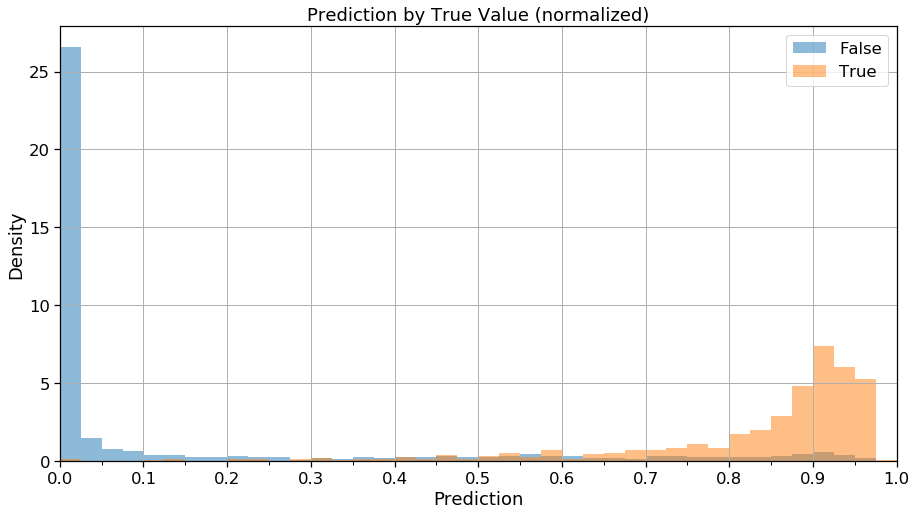

In [19]:
_ = predictions_hist(y_pred_proba, y_test, density=True)

             precision    recall  f1-score   support

      False       0.99      0.82      0.90      7315
       True       0.40      0.96      0.57       922

avg / total       0.93      0.84      0.86      8237



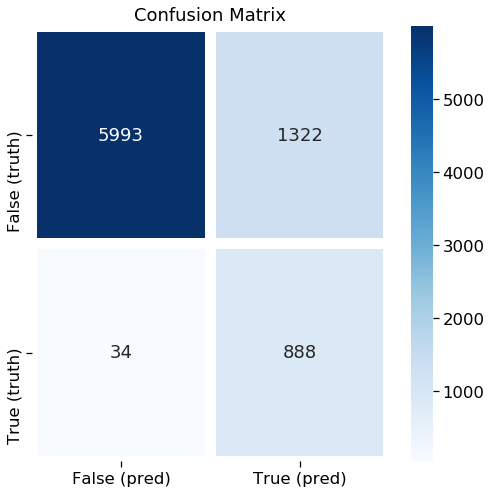

In [22]:
confusion_matrix_report(y_test, y_pred_proba, thres=0.4)

Utilize a função `log_loss` para calcular o log loss:

In [23]:
log_loss(y_test, y_pred_proba)

0.2785682008919767

### Visualização de árvores da LightGBM

In [24]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

Nós podemos ver acima que o nosso modelo foi treinado com `n_estimators=100` e `num_leaves=31`. Ou seja, o modelo compreende de 100 árvores de decisão, cada uma com até 31 folhas. Vamos plotar as 2 primeiras:

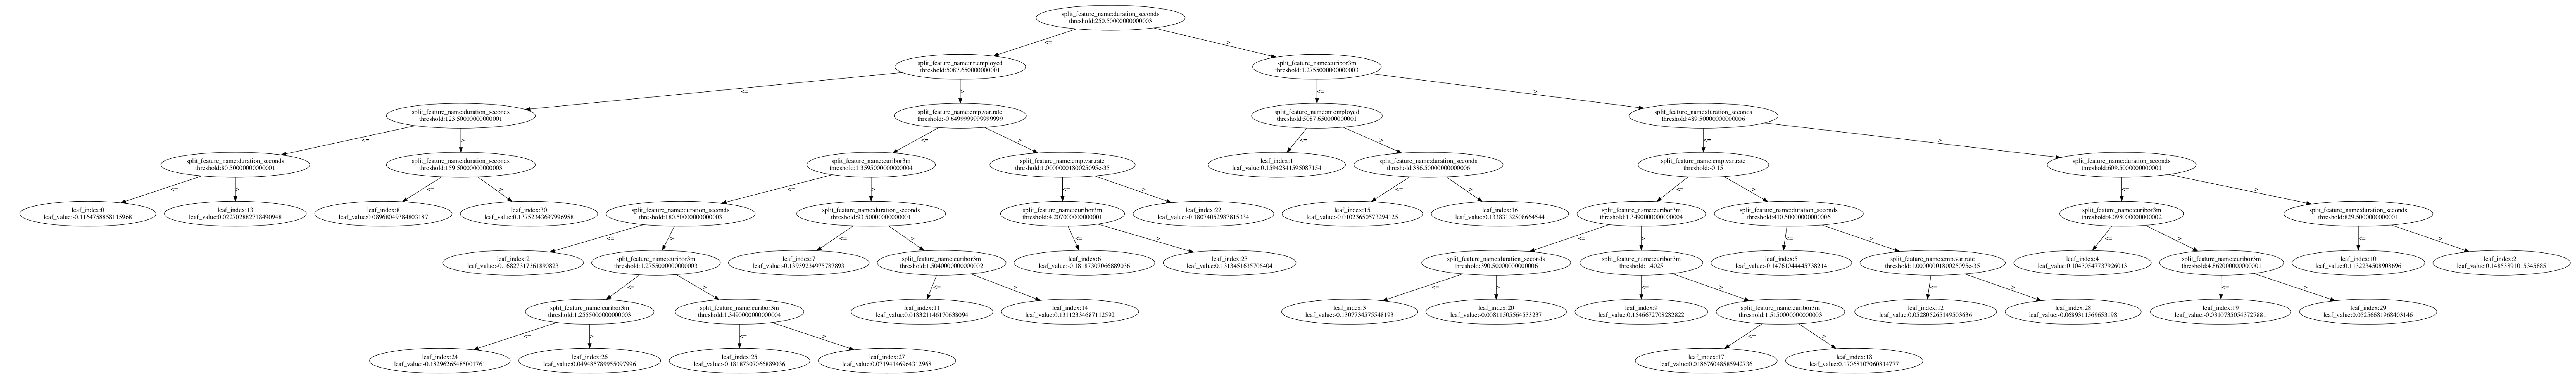

In [26]:
# create_tree_digraph(lgbm, tree_index=0)
_ = plot_tree(lgbm, tree_index=0, figsize=(150, 50))

Plote a segunda árvore de decisão:

In [ ]:
_ = plot_tree(lgbm, tree_index=1, figsize=(150, 50))

## Modelando com features categóricas e early stopping

Utilize o atributo `dtypes` da classe `DataFrame` para identificar o tipo da coluna `month`:

In [27]:
df.dtypes

duration_seconds      int64
duration_minutes    float64
duration_hours      float64
emp.var.rate        float64
nr.employed         float64
euribor3m           float64
month                object
contact               int64
loan                  int64
subscribed             bool
dtype: object

Para que a LightGBM trate a coluna `month` como uma feature categórica, é necessário que modiquemos seu tipo no Pandas:

In [28]:
df['month'] = df['month'].astype('category')

In [29]:
df.dtypes

duration_seconds       int64
duration_minutes     float64
duration_hours       float64
emp.var.rate         float64
nr.employed          float64
euribor3m            float64
month               category
contact                int64
loan                   int64
subscribed              bool
dtype: object

Vamos então adicionar a coluna `month` e refazer o split entre treino e teste:

In [39]:
X_cat = df.drop(columns=['subscribed'])

X_dev, X_test_cat, y_dev, y_test_cat = train_test_split(X_cat, y, test_size=0.2, 
                                                        random_state=0)

Para o early stopping, vamos quebrar o dataset de treino, que representa 80% dos dados, entre `dev` e `val`, de forma de `dev` fique com 60% dos dados e `val` com 20%. Ou seja, utilize a função `train_test_split` para criar `X_dev`, `X_val`, `y_dev` e `y_val`:

In [40]:
validation_size = 0.25

X_train_cat, X_val, y_train_cat, y_val = train_test_split(X_dev, y_dev, 
                                                          test_size=validation_size,
                                                          random_state=0)

In [41]:
lgbm_es = LGBMClassifier(n_estimators=3000,
                         class_weight='balanced', random_state=0)

Agora vamos invocar o método `fit` da nossa LightGBM, utilizando `X_dev` e `y_dev` para treino, além de setar `eval_set` e `early_stopping_rounds`, de forma que a LightGBM utilize o dataset de validação para parar a adição de árvores depois de 50 iterações sem melhoria na métrica:

In [42]:
lgbm_es.fit(X_train_cat, y_train_cat, eval_set=(X_val, y_val),
            early_stopping_rounds=50)

[1]	valid_0's binary_logloss: 0.631996
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.582628
[3]	valid_0's binary_logloss: 0.542288
[4]	valid_0's binary_logloss: 0.50829
[5]	valid_0's binary_logloss: 0.48012
[6]	valid_0's binary_logloss: 0.456214
[7]	valid_0's binary_logloss: 0.435905
[8]	valid_0's binary_logloss: 0.418744
[9]	valid_0's binary_logloss: 0.404
[10]	valid_0's binary_logloss: 0.39115
[11]	valid_0's binary_logloss: 0.380302
[12]	valid_0's binary_logloss: 0.371015
[13]	valid_0's binary_logloss: 0.363205
[14]	valid_0's binary_logloss: 0.356184
[15]	valid_0's binary_logloss: 0.350041
[16]	valid_0's binary_logloss: 0.344405
[17]	valid_0's binary_logloss: 0.339631
[18]	valid_0's binary_logloss: 0.335269
[19]	valid_0's binary_logloss: 0.331904
[20]	valid_0's binary_logloss: 0.328489
[21]	valid_0's binary_logloss: 0.325775
[22]	valid_0's binary_logloss: 0.323223
[23]	valid_0's binary_logloss: 0.320757
[24]	valid_0's binary_logloss: 0.

[264]	valid_0's binary_logloss: 0.288843
[265]	valid_0's binary_logloss: 0.288754
[266]	valid_0's binary_logloss: 0.288699
[267]	valid_0's binary_logloss: 0.28868
[268]	valid_0's binary_logloss: 0.288727
[269]	valid_0's binary_logloss: 0.288636
[270]	valid_0's binary_logloss: 0.288615
[271]	valid_0's binary_logloss: 0.288681
[272]	valid_0's binary_logloss: 0.28848
[273]	valid_0's binary_logloss: 0.288421
[274]	valid_0's binary_logloss: 0.288468
[275]	valid_0's binary_logloss: 0.288535
[276]	valid_0's binary_logloss: 0.288548
[277]	valid_0's binary_logloss: 0.288604
[278]	valid_0's binary_logloss: 0.288436
[279]	valid_0's binary_logloss: 0.288575
[280]	valid_0's binary_logloss: 0.288491
[281]	valid_0's binary_logloss: 0.288447
[282]	valid_0's binary_logloss: 0.288433
[283]	valid_0's binary_logloss: 0.2884
[284]	valid_0's binary_logloss: 0.288339
[285]	valid_0's binary_logloss: 0.288341
[286]	valid_0's binary_logloss: 0.288354
[287]	valid_0's binary_logloss: 0.288397
[288]	valid_0's bina

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [43]:
y_pred_proba_es = lgbm_es.predict_proba(X_test_cat)[:, 1]

In [44]:
log_loss(y_test_cat, y_pred_proba_es)

0.26152543070029061

## Tunando o parâmetro `learning_rate` também

Defina a variável `learning_rate` de forma que seja uma lista contendo os valores `0.01`, `0.03` e `0.1`:

In [45]:
max_n_estimators = 3000
early_stopping_rounds = 50
learning_rates = [0.01, 0.03, 0.1]

In [47]:
lgbm_lr = LGBMClassifier(n_estimators=max_n_estimators, 
                         class_weight='balanced', random_state=0)

Preencha o código abaixo, de forma que a cada iteração do loop, seja treinada uma LightGBM com early stopping:

In [53]:
results = pd.DataFrame(columns=['learning_rate', 'best_n_estimators', 'best_log_loss'])

for learning_rate in tqdm(learning_rates):
    lgbm_lr.learning_rate = learning_rate
    
    lgbm_lr.fit(X_train_cat, y_train_cat, eval_set=(X_val, y_val),
               early_stopping_rounds=early_stopping_rounds, verbose=False)
    
    results = results.append({'learning_rate': learning_rate, 
                              'best_n_estimators': lgbm_lr.best_iteration_,
                              'best_log_loss': lgbm_lr.best_score_['valid_0']['binary_logloss']},
                             ignore_index=True)

100%|██████████| 3/3 [00:11<00:00,  3.74s/it]


Na célula acima, é possível ver que a LightGBM salva o melhor valor encontrada para `n_estimators` no atributo `best_iteration_` e o seu desempenho em um dicionário que pode ser acessado pelo atributo `best_score_`.

Vamos então exibir os resultados:

In [54]:
results['learning_rate'] = results['learning_rate']
results['best_n_estimators'] = results['best_n_estimators'].astype(int)

results

,learning_rate,best_n_estimators,best_log_loss
0,0.01,1768,0.289414
1,0.03,785,0.287982
2,0.10,302,0.288279


No mais, note que, quanto menor o `learning_rate`, maior é o `n_estimators`. Por consequência, maior também serão os tempos de treino e de predição.

### Grid search com os melhores conjuntos de parâmetros

Vamos utilizar os melhores resultados obtidos na seção anterior e conferir via validação cruzada qual, de fato, é o melhor conjunto de hyper-parâmetros.

Para isso, a próxima célula cria grids de parâmetros. Note que isso é muito mais eficiente do que se criar somente um grid com todos esses parâmetros, já que o número de conjuntos de parâmetros a serem treinados passaria a ser a combinação de todos os valores (8*8=`64` ao invés de somente `8`).

In [55]:
param_grids = [
    {'learning_rate': [0.01], 'n_estimators': [1768]},
    {'learning_rate': [0.03], 'n_estimators': [785]},
    {'learning_rate': [0.1], 'n_estimators': [302]}
]

No algoritmo de cross-validation do scikit-learn, quanto maior a métrica, melhor o modelo. Para poder-se utilizar esse tipo de algoritmo com métricas que tentam minimizar um erro (e.g., log loss), a métrica é negada, ou seja, multiplicada por `-1`.

A [lista de métricas pré-definidas](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules) pode ser encontrada na documentação do scikit-learn.

In [56]:
scoring = 'neg_log_loss'

Agora, instancie a classe `GridSearchCV` com 3 folds de validação cruzada e o parâmetro `verbose=2`, além de passar outros parâmetros necessários:

In [58]:
grid_search_cv = GridSearchCV(lgbm_lr, param_grids, scoring=scoring, 
                              cv=3, verbose=2)

In [59]:
grid_search_cv.fit(X_train_cat, y_train_cat, verbose=False)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01, n_estimators=1768 ...........................
[CV] ............ learning_rate=0.01, n_estimators=1768, total=   4.6s
[CV] learning_rate=0.01, n_estimators=1768 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ............ learning_rate=0.01, n_estimators=1768, total=   4.7s
[CV] learning_rate=0.01, n_estimators=1768 ...........................
[CV] ............ learning_rate=0.01, n_estimators=1768, total=   3.5s
[CV] learning_rate=0.03, n_estimators=785 ............................
[CV] ............. learning_rate=0.03, n_estimators=785, total=   1.6s
[CV] learning_rate=0.03, n_estimators=785 ............................
[CV] ............. learning_rate=0.03, n_estimators=785, total=   1.6s
[CV] learning_rate=0.03, n_estimators=785 ............................
[CV] ............. learning_rate=0.03, n_estimators=785, total=   1.7s
[CV] learning_rate=0.1, n_estimators=302 .............................
[CV] .............. learning_rate=0.1, n_estimators=302, total=   0.5s
[CV] learning_rate=0.1, n_estimators=302 .............................
[CV] .............. learning_rate=0.1, n_estimators=302, total=   0.5s
[CV] learning_rate=0.1, n_estimators=302 .............................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': [0.01], 'n_estimators': [1768]}, {'learning_rate': [0.03], 'n_estimators': [785]}, {'learning_rate': [0.1], 'n_estimators': [302]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

A função `grid_search_report` foi criada por nós para facilitar a visualização dos resultados:

In [61]:
grid_search_report(grid_search_cv.grid_scores_, scoring, scoring_alias='log_loss', 
                   include_learning_rate=True)

/Users/gabrielcs/anaconda/envs/tera-fev2019/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,mean_log_loss,std,n_estimators,learning_rate
2,0.273714,0.005786,302,0.10
1,0.274739,0.006891,785,0.03
0,0.277617,0.006237,1768,0.01


In [62]:
grid_search_cv.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=302, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

Por coincidência, podemos ver que o melhor learning_rate encontrado é justamente o valor default. Ou seja, esse modelo é o mesmo da seção anterior.

## Interpretando o modelo

Para interpretar o modelo, utilizaremos o [SHAP](https://github.com/slundberg/shap).

Para não despendermos muito tempo calculando os SHAP values, utilizaremos uma amostra aleatória de 100 exemplos. Além disso, vamos utilizar o dataset/modelo sem variáveis categóricas por simplicidade:

In [65]:
X_train_sample = X_train.sample(1_000, random_state=0)

O `TreeExplainer`, ao contrário do `KernelExplainer` que é genérico, é otimizado para modelos baseados em árvores e tem suporte à LightGBM.

In [66]:
explainer = shap.TreeExplainer(lgbm, data=X_train_sample)
shap_values = explainer.shap_values(X_train_sample)

Os SHAP values são nada mais do que a contribuição de cada variável para cada predição. A sua unidade é sempre a mesma unidade do target.

Com os SHAP values calculados, vamos plotar os feature importances:

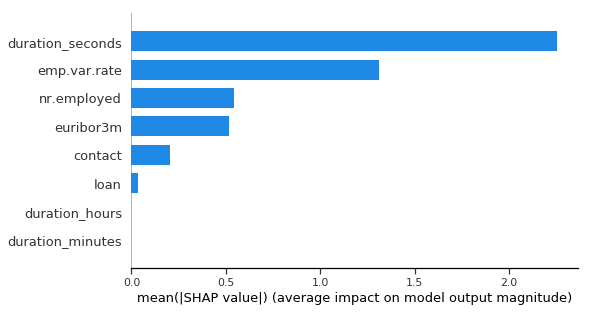

In [67]:
shap.summary_plot(shap_values, X_train_sample, plot_type='bar')

Modifique o parâmetro `plot_type='bar'` para `plot_type='dot'`. Veja que agora é possível fazer uma análise mais aprofundada com o summary plot:

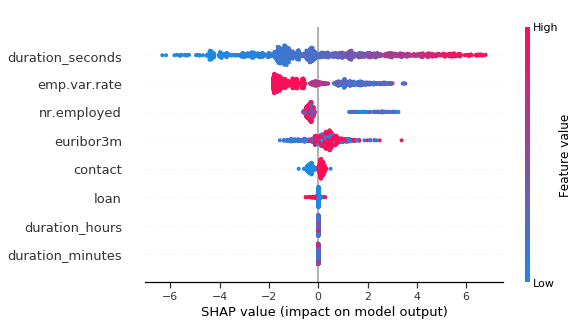

In [68]:
shap.summary_plot(shap_values, X_train_sample, plot_type='dot')

### Vamos dar um deep dive em algumas features

Pense no `dependence_plot` como um zoom que nós podemos dar para entender o que o modelo aprendeu com relação a uma feature específica:

In [69]:
def dependence_plot(feature, show=True):
    shap.dependence_plot(feature, shap_values, X_train_sample, 
                         interaction_index=feature, show=show)

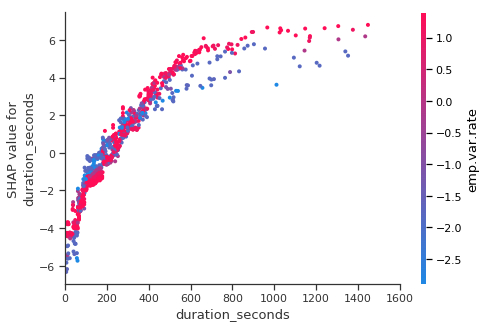

In [72]:
shap.dependence_plot('duration_seconds', shap_values, 
                     X_train_sample, show=False)
_ = plt.xlim(0, 1600)

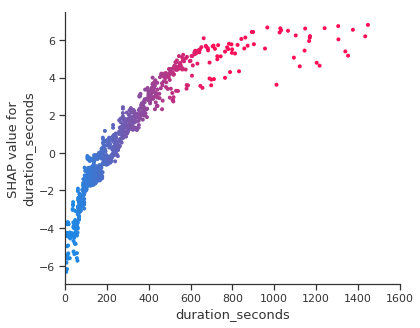

In [70]:
# show=False e o xlim na linha de baixo é para não exibirmos outliers
dependence_plot('duration_seconds', show=False)
_ = plt.xlim(0, 1600)

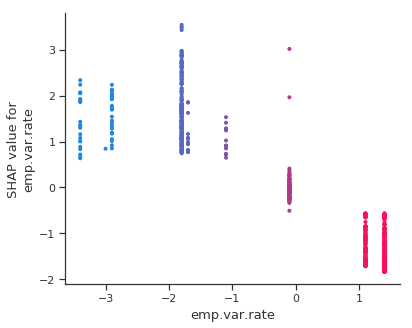

In [71]:
dependence_plot('emp.var.rate')

O nome `dependence plot` é dado ao fato de que o SHAP automaticamente identifica qual é a variável que mais interage com a variável em questão e exibe o seu comportamento dependendo dessa outra variável.

O parâmetro `interaction_index` nos permite selecionar qualquer outra variável para essa comparação. Setanto esse parâmetro para a própria feature, deixamos de ver interação dela com outras.

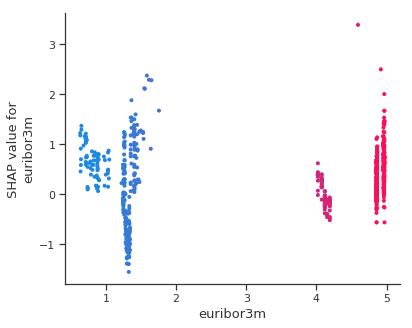

In [73]:
feature = 'euribor3m'
shap.dependence_plot(feature, shap_values, X_train_sample, 
                     interaction_index=feature)

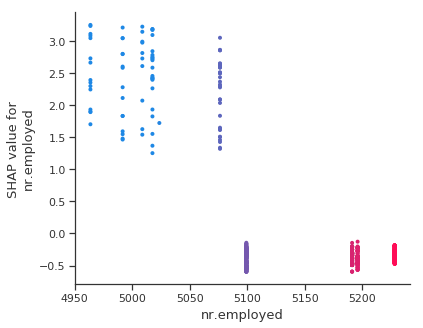

In [74]:
feature = 'nr.employed'
shap.dependence_plot(feature, shap_values, X_train_sample, 
                     interaction_index=feature)

### Extra: vamos analisar algumas predições

Lembram da função logística (a.k.a., sigmoid)?

In [75]:
def logistic(x):
    return math.exp(x) / (math.exp(x) + 1)

In [76]:
explainer.expected_value, logistic(explainer.expected_value)

(-3.6803268050782534, 0.024594587230901566)

A célula de cima nos diz que o valor esperado (ou seja a média) das predições no dataset de teste é ~2.4%.

O `force_plot` é uma analogia à física. As variáveis em vermelho "empurram" o valor da predição para ser mais alto, quanto as variáveis em azul "empurram" o valor da predição para baixo.

In [77]:
def force_plot(id_):
    return shap.force_plot(explainer.expected_value, shap_values[id_, :], 
                           X_train_sample.iloc[id_, :])

Uma ótima avaliação de um classificador pode ser analisar os force plots dos falsos positivos scores mais altos e os falsos negativos com scores mais baixos. Essa estratégia tem o potencial de 1) ajudar a identificar features relevantes que não estão no modelo; e/ou 2) fazer com que stakeholders ganhem confiança no modelo caso os erros façam sentido.

Vamos aplicar o `force_plot` à primeira observação da amostra aleatória:

In [78]:
force_plot(id_=0)

In [79]:
logistic(-4.99)

0.006759660510713249

Para facilitar a interpretação do valor predito, basta aplicar a função logística:

In [ ]:
logistic(-8.84)

In [80]:
force_plot(id_=1)

In [81]:
logistic(2.06)

0.8869541699279211